# 08. PyTorch Paper Replicating

## 0. Get setup

In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 27.46 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [6]:
data_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
data_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

In [7]:
import os

train_dir = data_path / "train"
test_dir = data_path / "test"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()

])



train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=transform,
                                                                              batch_size=BATCH_SIZE,
                                                                              num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [8]:
images, labels = next(iter(train_dataloader))
images.shape, labels

(torch.Size([32, 3, 224, 224]),
 tensor([0, 2, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 1, 2,
         1, 0, 2, 0, 1, 0, 0, 0]))

In [9]:
image, label = images[0], labels[0]

(-0.5, 223.5, 223.5, -0.5)

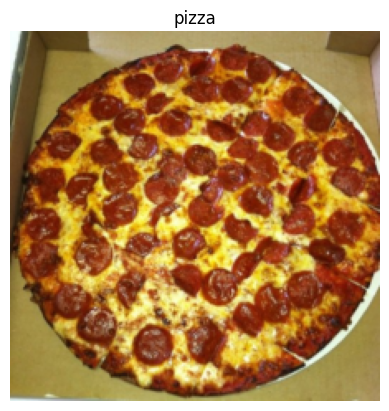

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

## 3. Replicating ViT

## 4. Equation 1: Split data into patches and creating the class, position and path embedding

* Input shape: $H\times{W}\times{C}$
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$

* H = height
* W = width
* C = color channels
* P = patch size
* N = number of paches = (height * width) / p^2
* D = constant latent vector size = embedding dimension

### 4.1 Calculate input and output shapes by hand

In [1]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / (patch_size ** 2))
number_of_patches

196

In [2]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

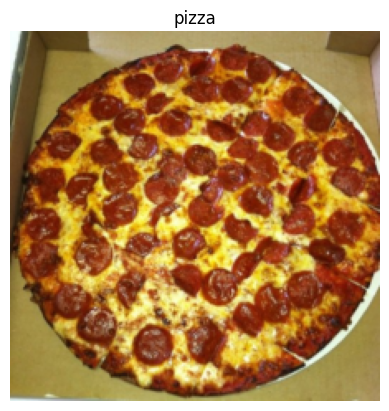

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

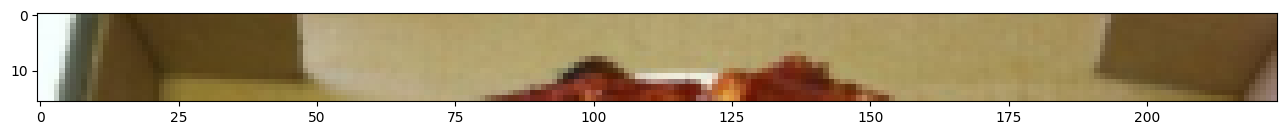

In [15]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

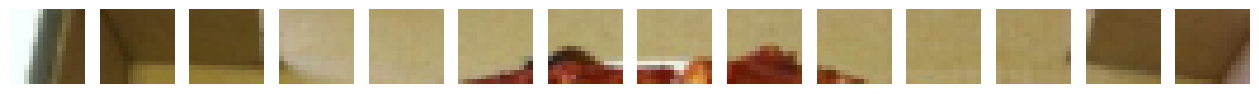

In [20]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
fig, axis = plt.subplots(nrows=1,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))
for i, patch in enumerate(range(0, img_size, patch_size)):
  axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axis[i].set_xlabel(i+1)
  axis[i].set_xticks([])
  axis[i].set_yticks([])
  axis[i].axis("off")

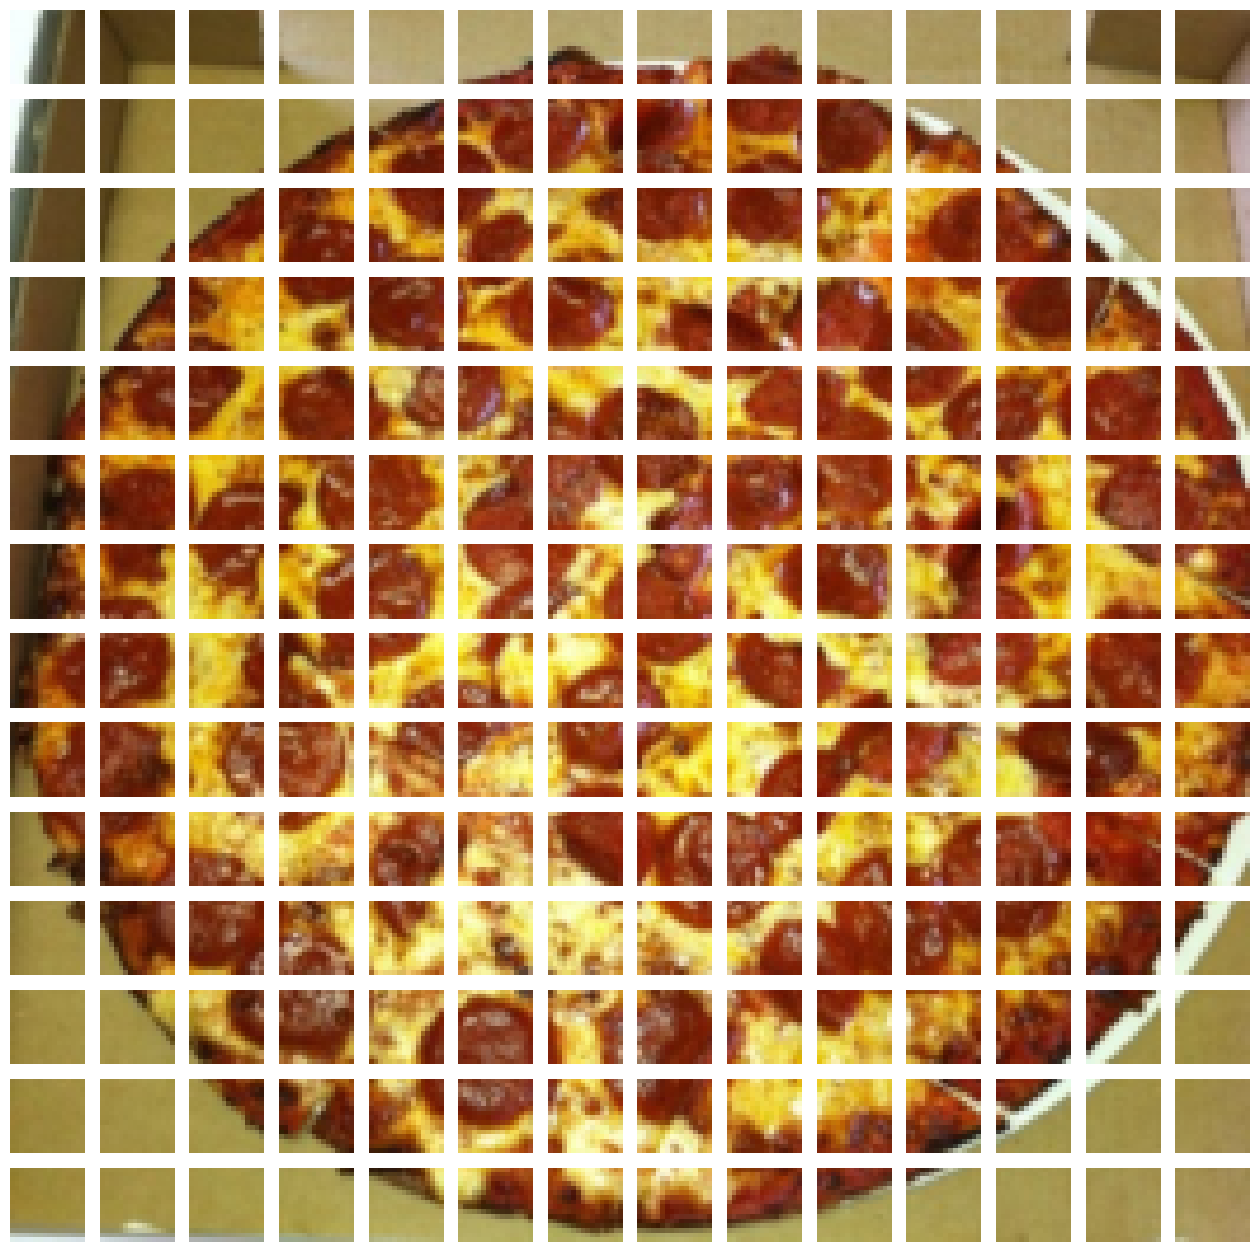

In [21]:
 # Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True, figsize=(patch_size, patch_size))

for i, patch_row in enumerate(range(0, img_size, patch_size)):
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    axis[i][j].imshow(image_permuted[patch_row:patch_row + patch_size, patch_col:patch_col+patch_size, :])
    axis[i][j].set_xlabel(i+1)
    axis[i][j].set_xticks([])
    axis[i][j].set_yticks([])
    axis[i][j].axis("off")